In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report


from warnings import filterwarnings
filterwarnings('ignore')

### Kaggle: Wine Quality Dataset

In [2]:
df=pd.read_csv("D:\DATA SCIENCE\Internship\CodeClause\Wine Quality Prediction\WineQT.csv")

In [3]:
# Dataset First Look
df.head(5)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0            7.4              0.70         0.00             1.9      0.076  \
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates   
0                 11.0                  34.0   0.9978  3.51       0.56  \
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9.8        5   2  
3      9.8        6   3  
4      9.4        5   4

In [4]:
df.drop(columns='Id',inplace=True)

In [5]:
# Dataset Rows & Columns count
df.shape

(1143, 12)

In [6]:
# Dataset Info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


In [7]:
# Dataset Duplicate Value Count
df.duplicated().sum()

125

In [8]:
# Missing Values/Null Values Count
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [9]:
# Dataset Describe
df.describe().style.background_gradient()

### Data Visualization

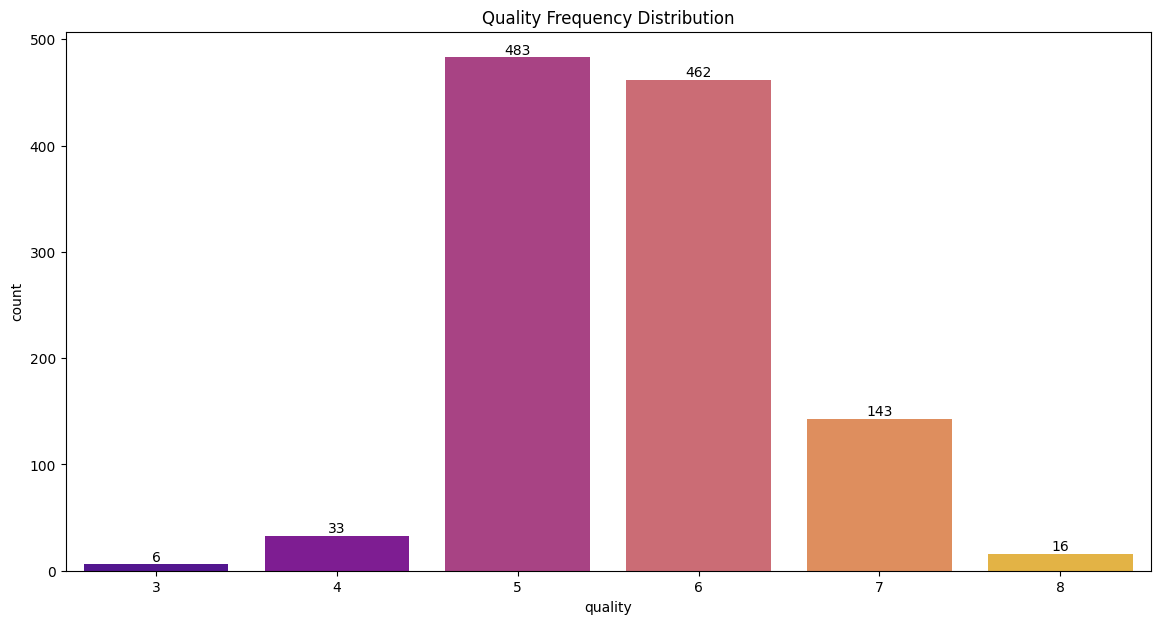

In [10]:
plt.figure(figsize=(14,7))
ax=sns.countplot(x='quality',data=df,palette='plasma')
plt.title('Quality Frequency Distribution')
for label in ax.containers:
    ax.bar_label(label)
plt.show()

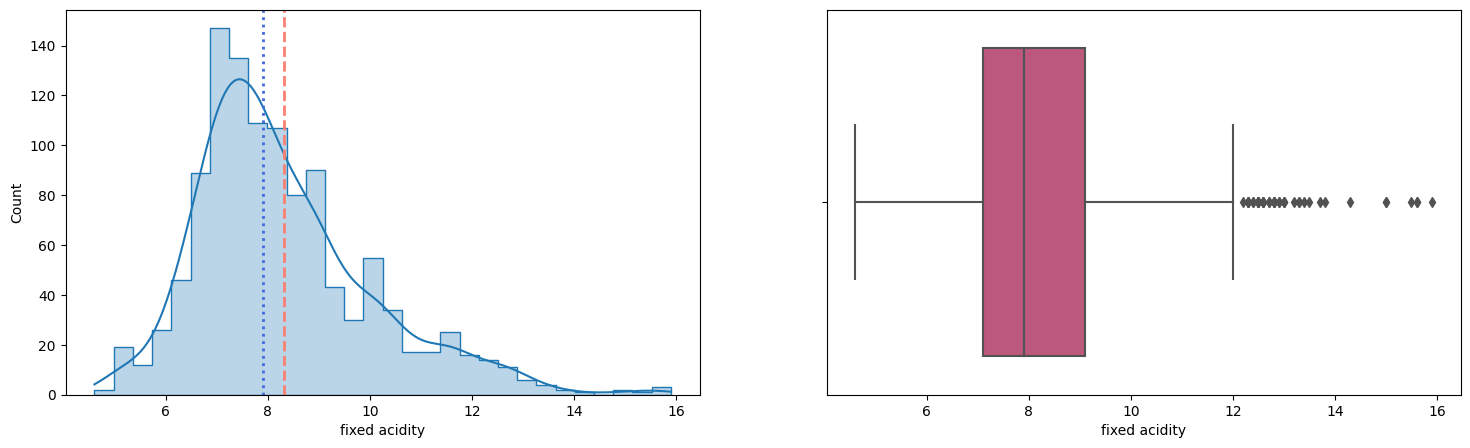

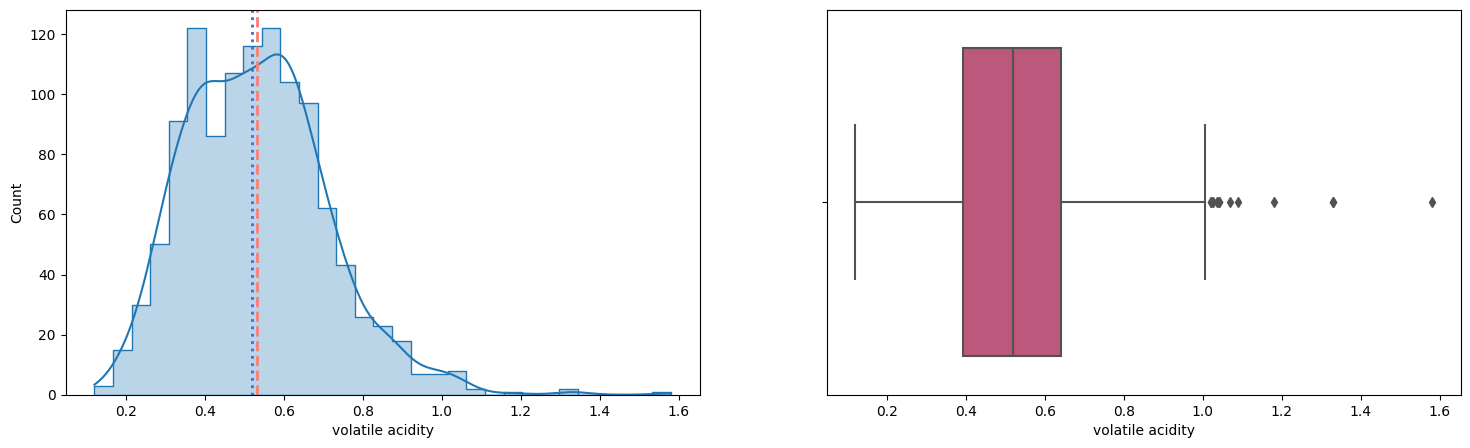

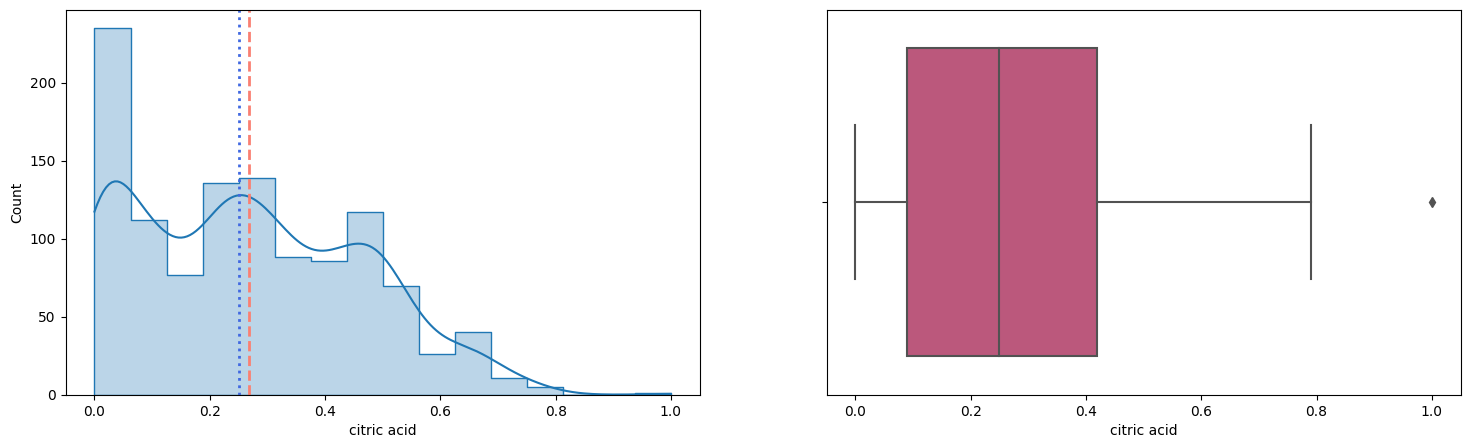

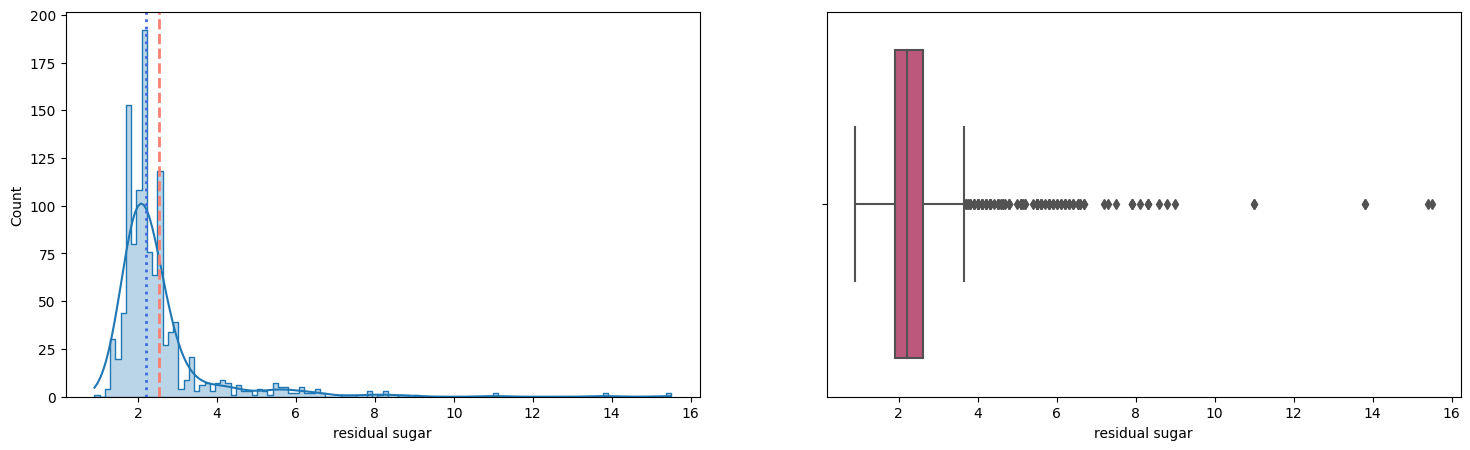

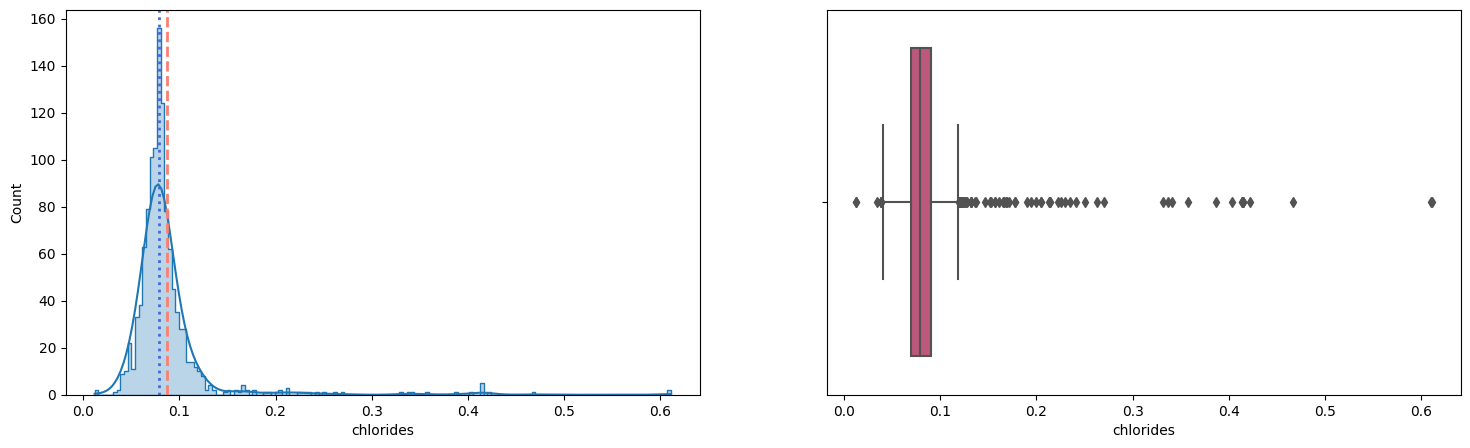

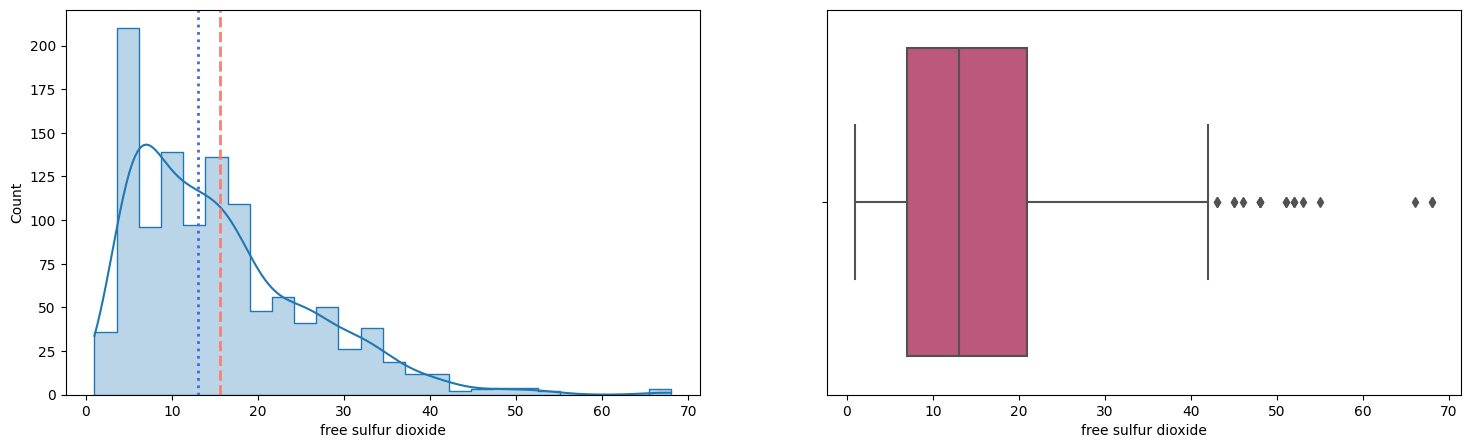

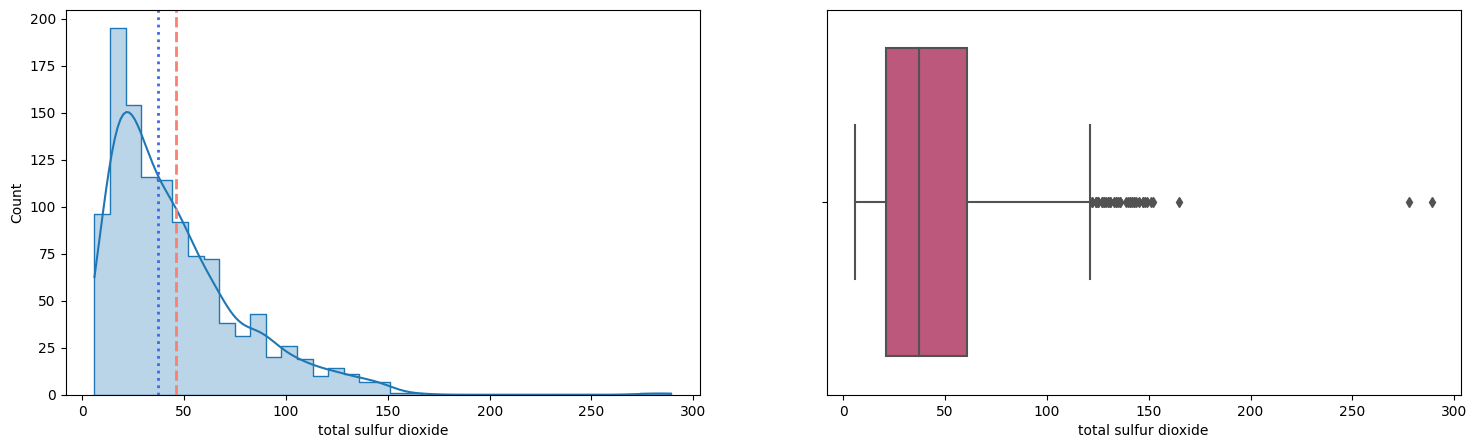

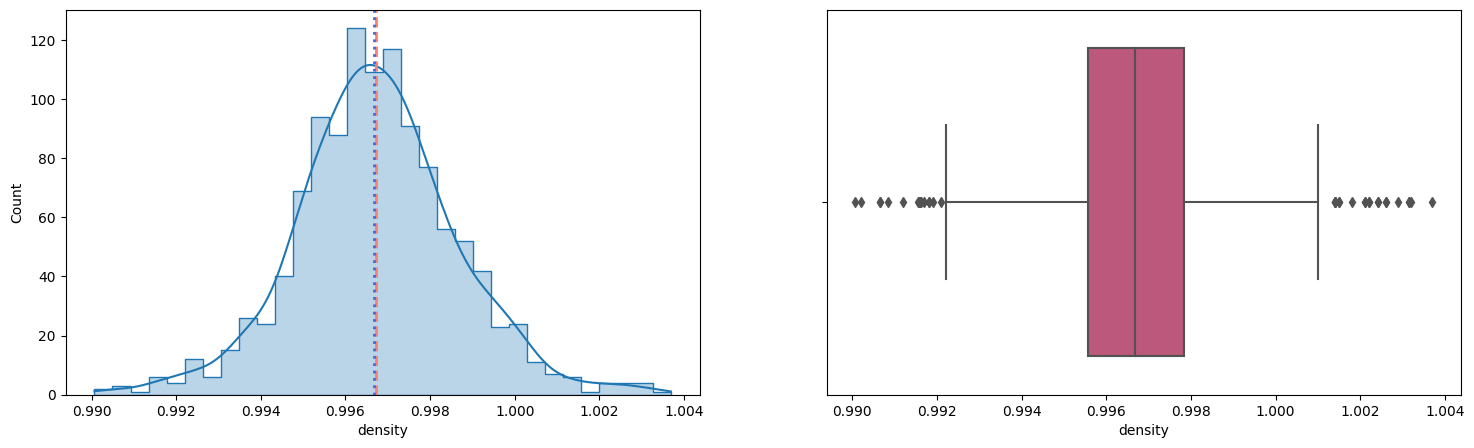

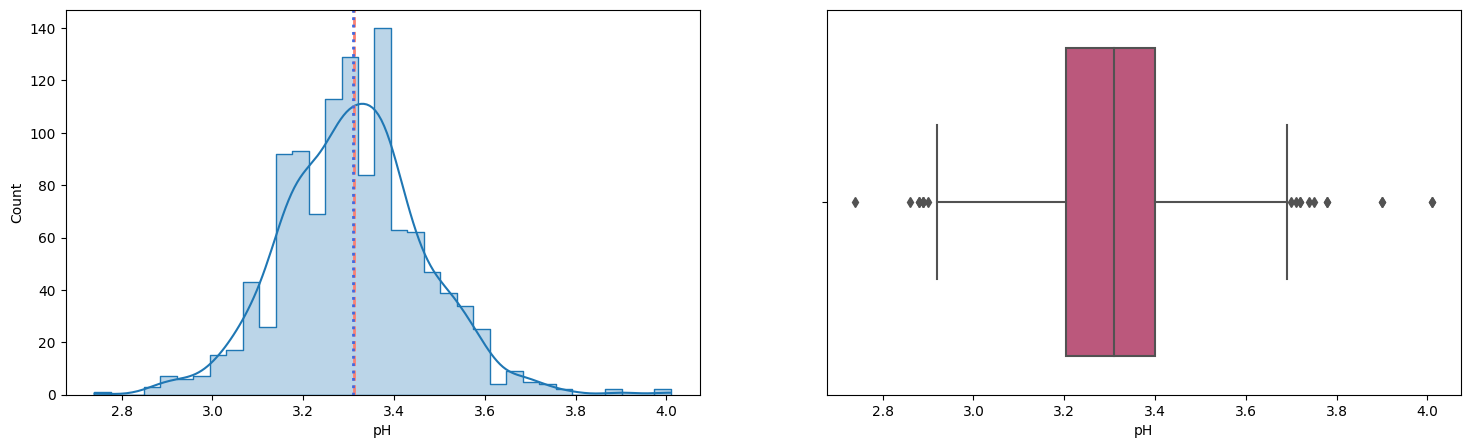

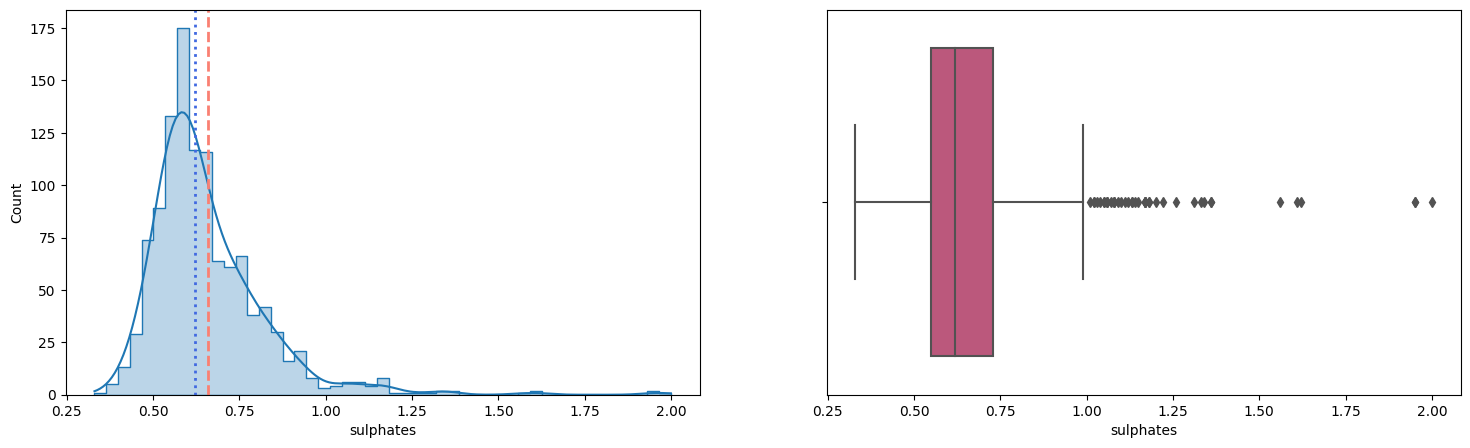

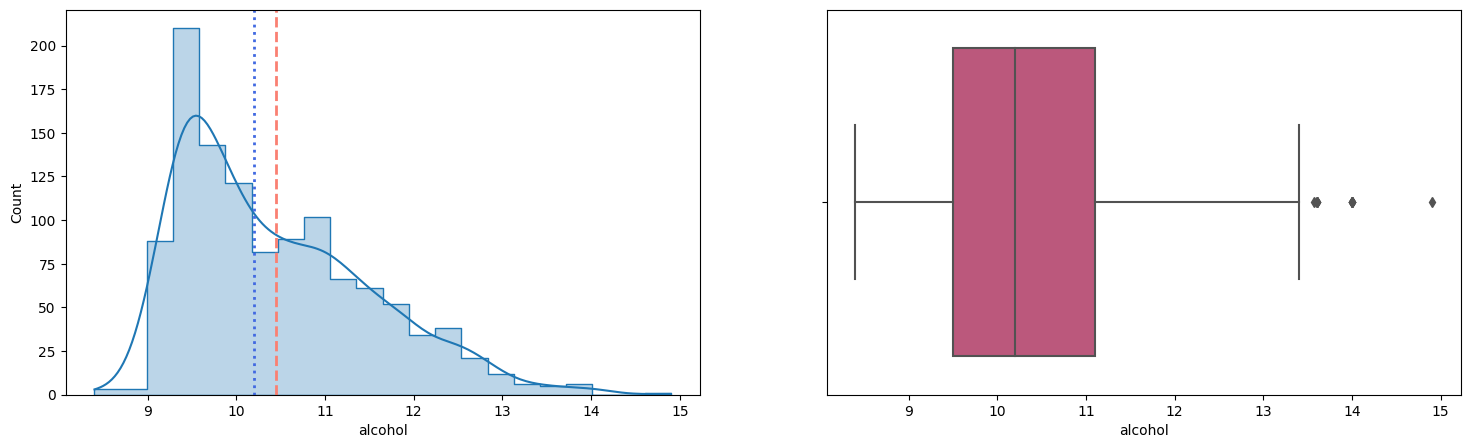

In [11]:
for var in df.drop(columns='quality').columns:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(18,5))
    sns.histplot(df,x=var,kde=True,ax=ax1,element='step',alpha=0.3)
    ax1.axvline(df[var].mean(),color='salmon', linestyle='dashed', linewidth=2)
    ax1.axvline(df[var].median(),color='royalblue', linestyle=':', linewidth=2)
    sns.boxplot(df,x=var,ax=ax2,palette="plasma")
    plt.show()

### 
* Despite the presence of outliers in the wine quality dataset, the analysis will proceed with the existing columns due to the constraint of not being able to remove any data given the small dataset size.
* There is a presence of moderate to high skewness in some of the features.It needs to be treated.

In [12]:
 df.drop(columns='quality').skew()

fixed acidity           1.044930
volatile acidity        0.681547
citric acid             0.371561
residual sugar          4.361096
chlorides               6.026360
free sulfur dioxide     1.231261
total sulfur dioxide    1.665766
density                 0.102395
pH                      0.221138
sulphates               2.497266
alcohol                 0.863313
dtype: float64

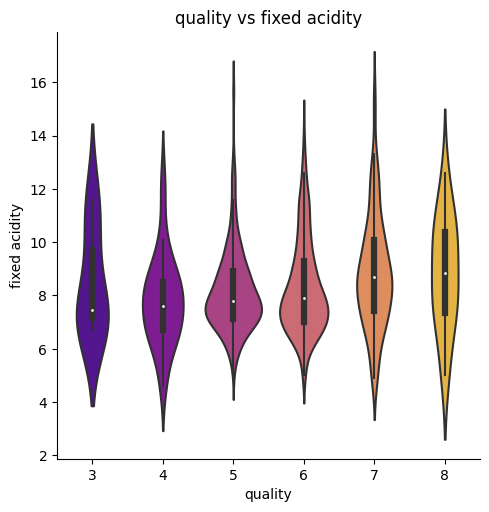

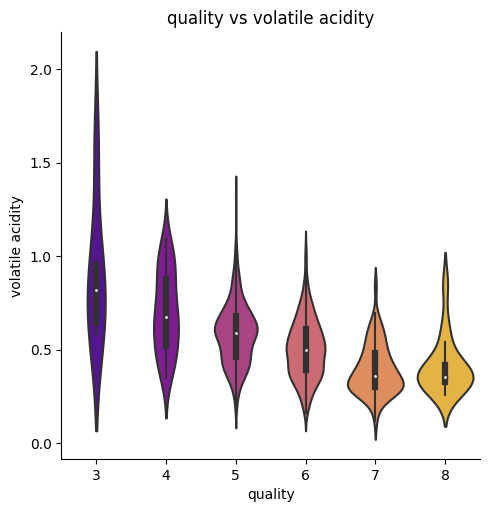

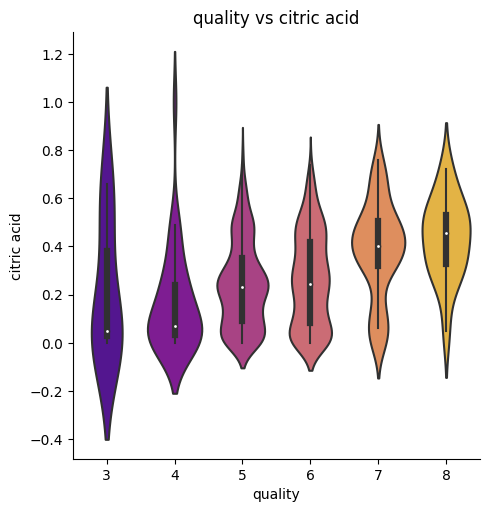

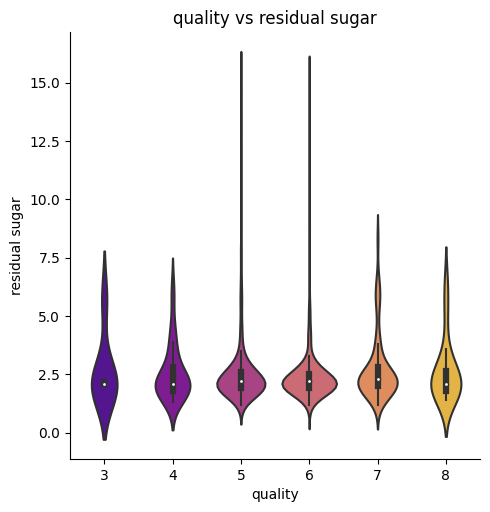

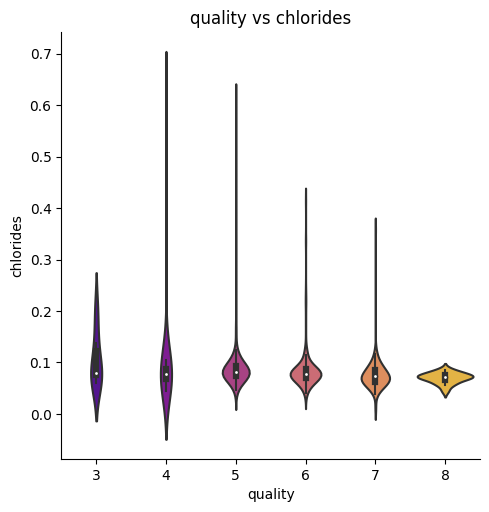

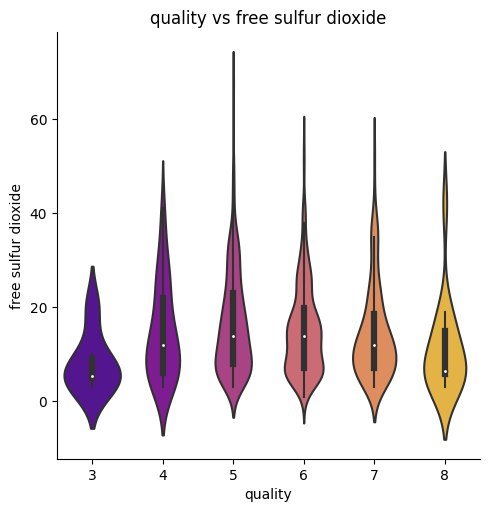

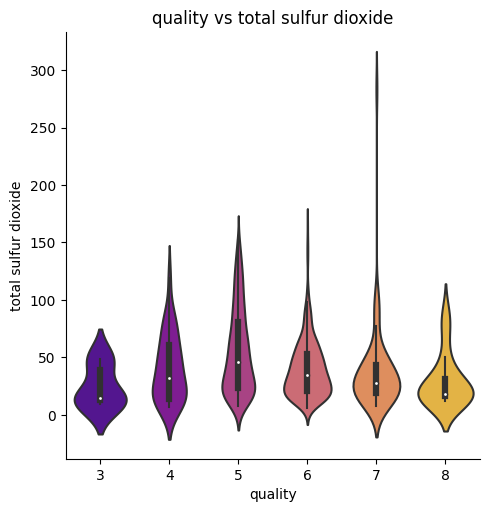

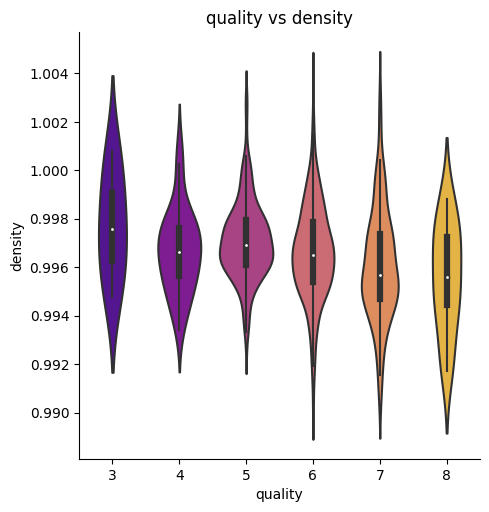

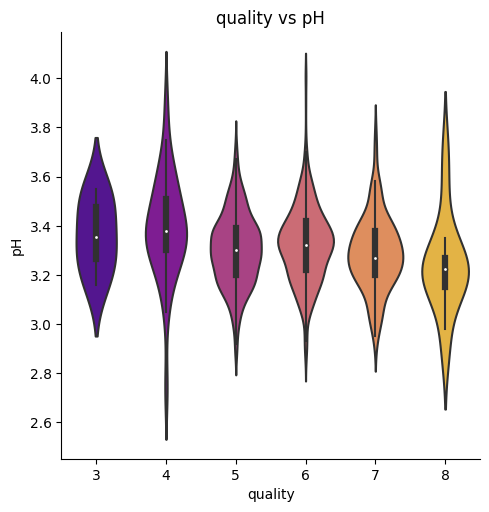

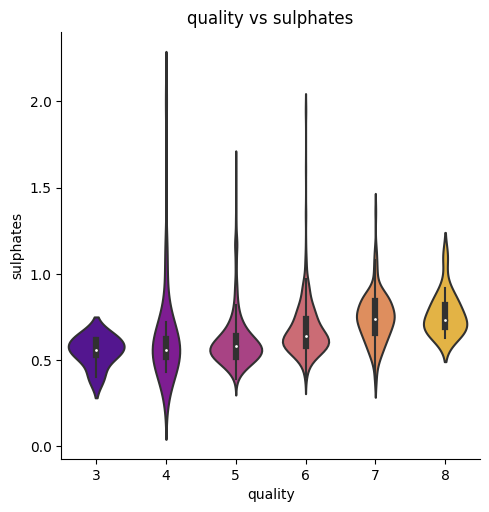

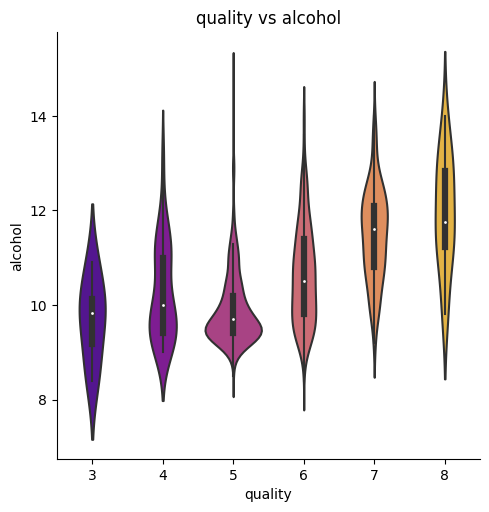

In [13]:
for var in df.drop(columns='quality').columns:
    sns.catplot(x='quality',y=var,data=df,kind='violin',palette='plasma')
    plt.ylabel(var)
    plt.xlabel('quality')
    plt.title('quality' + ' vs ' +var)
    plt.show()

### Correlation Heatmap

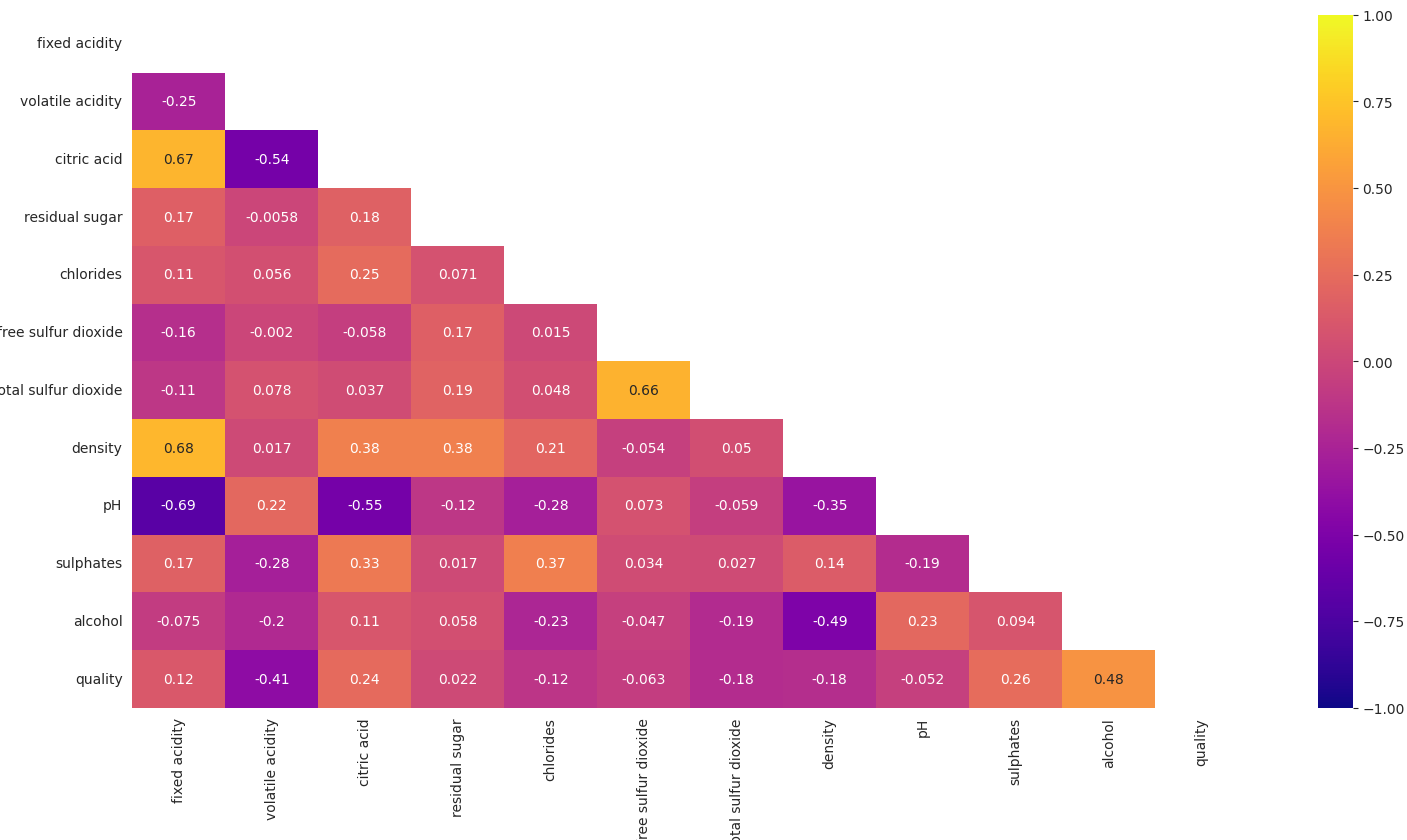

In [14]:
corr = df.corr()
mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(18, 9))
    ax = sns.heatmap(corr , mask=mask, vmin = -1,vmax=1, annot = True, cmap="plasma")

### Boxplot of the correlation between: 'quality', and 'alcohol'

In [15]:
import plotly.graph_objects as go

fig = go.Figure()

for x in df['quality'].unique():
    fig.add_trace(
        go.Box(
            x=df[df.quality == x].alcohol,
            y=df[df.quality == x].quality,
            name="Quality " + str(x),
        )
    )

fig.update_layout(yaxis_title="quality", xaxis_title="alcohol")
fig.update_traces(orientation="h")
fig.show()

### 
* The higher the alcohol level, the better the quality of the wine.

### Pair Plot

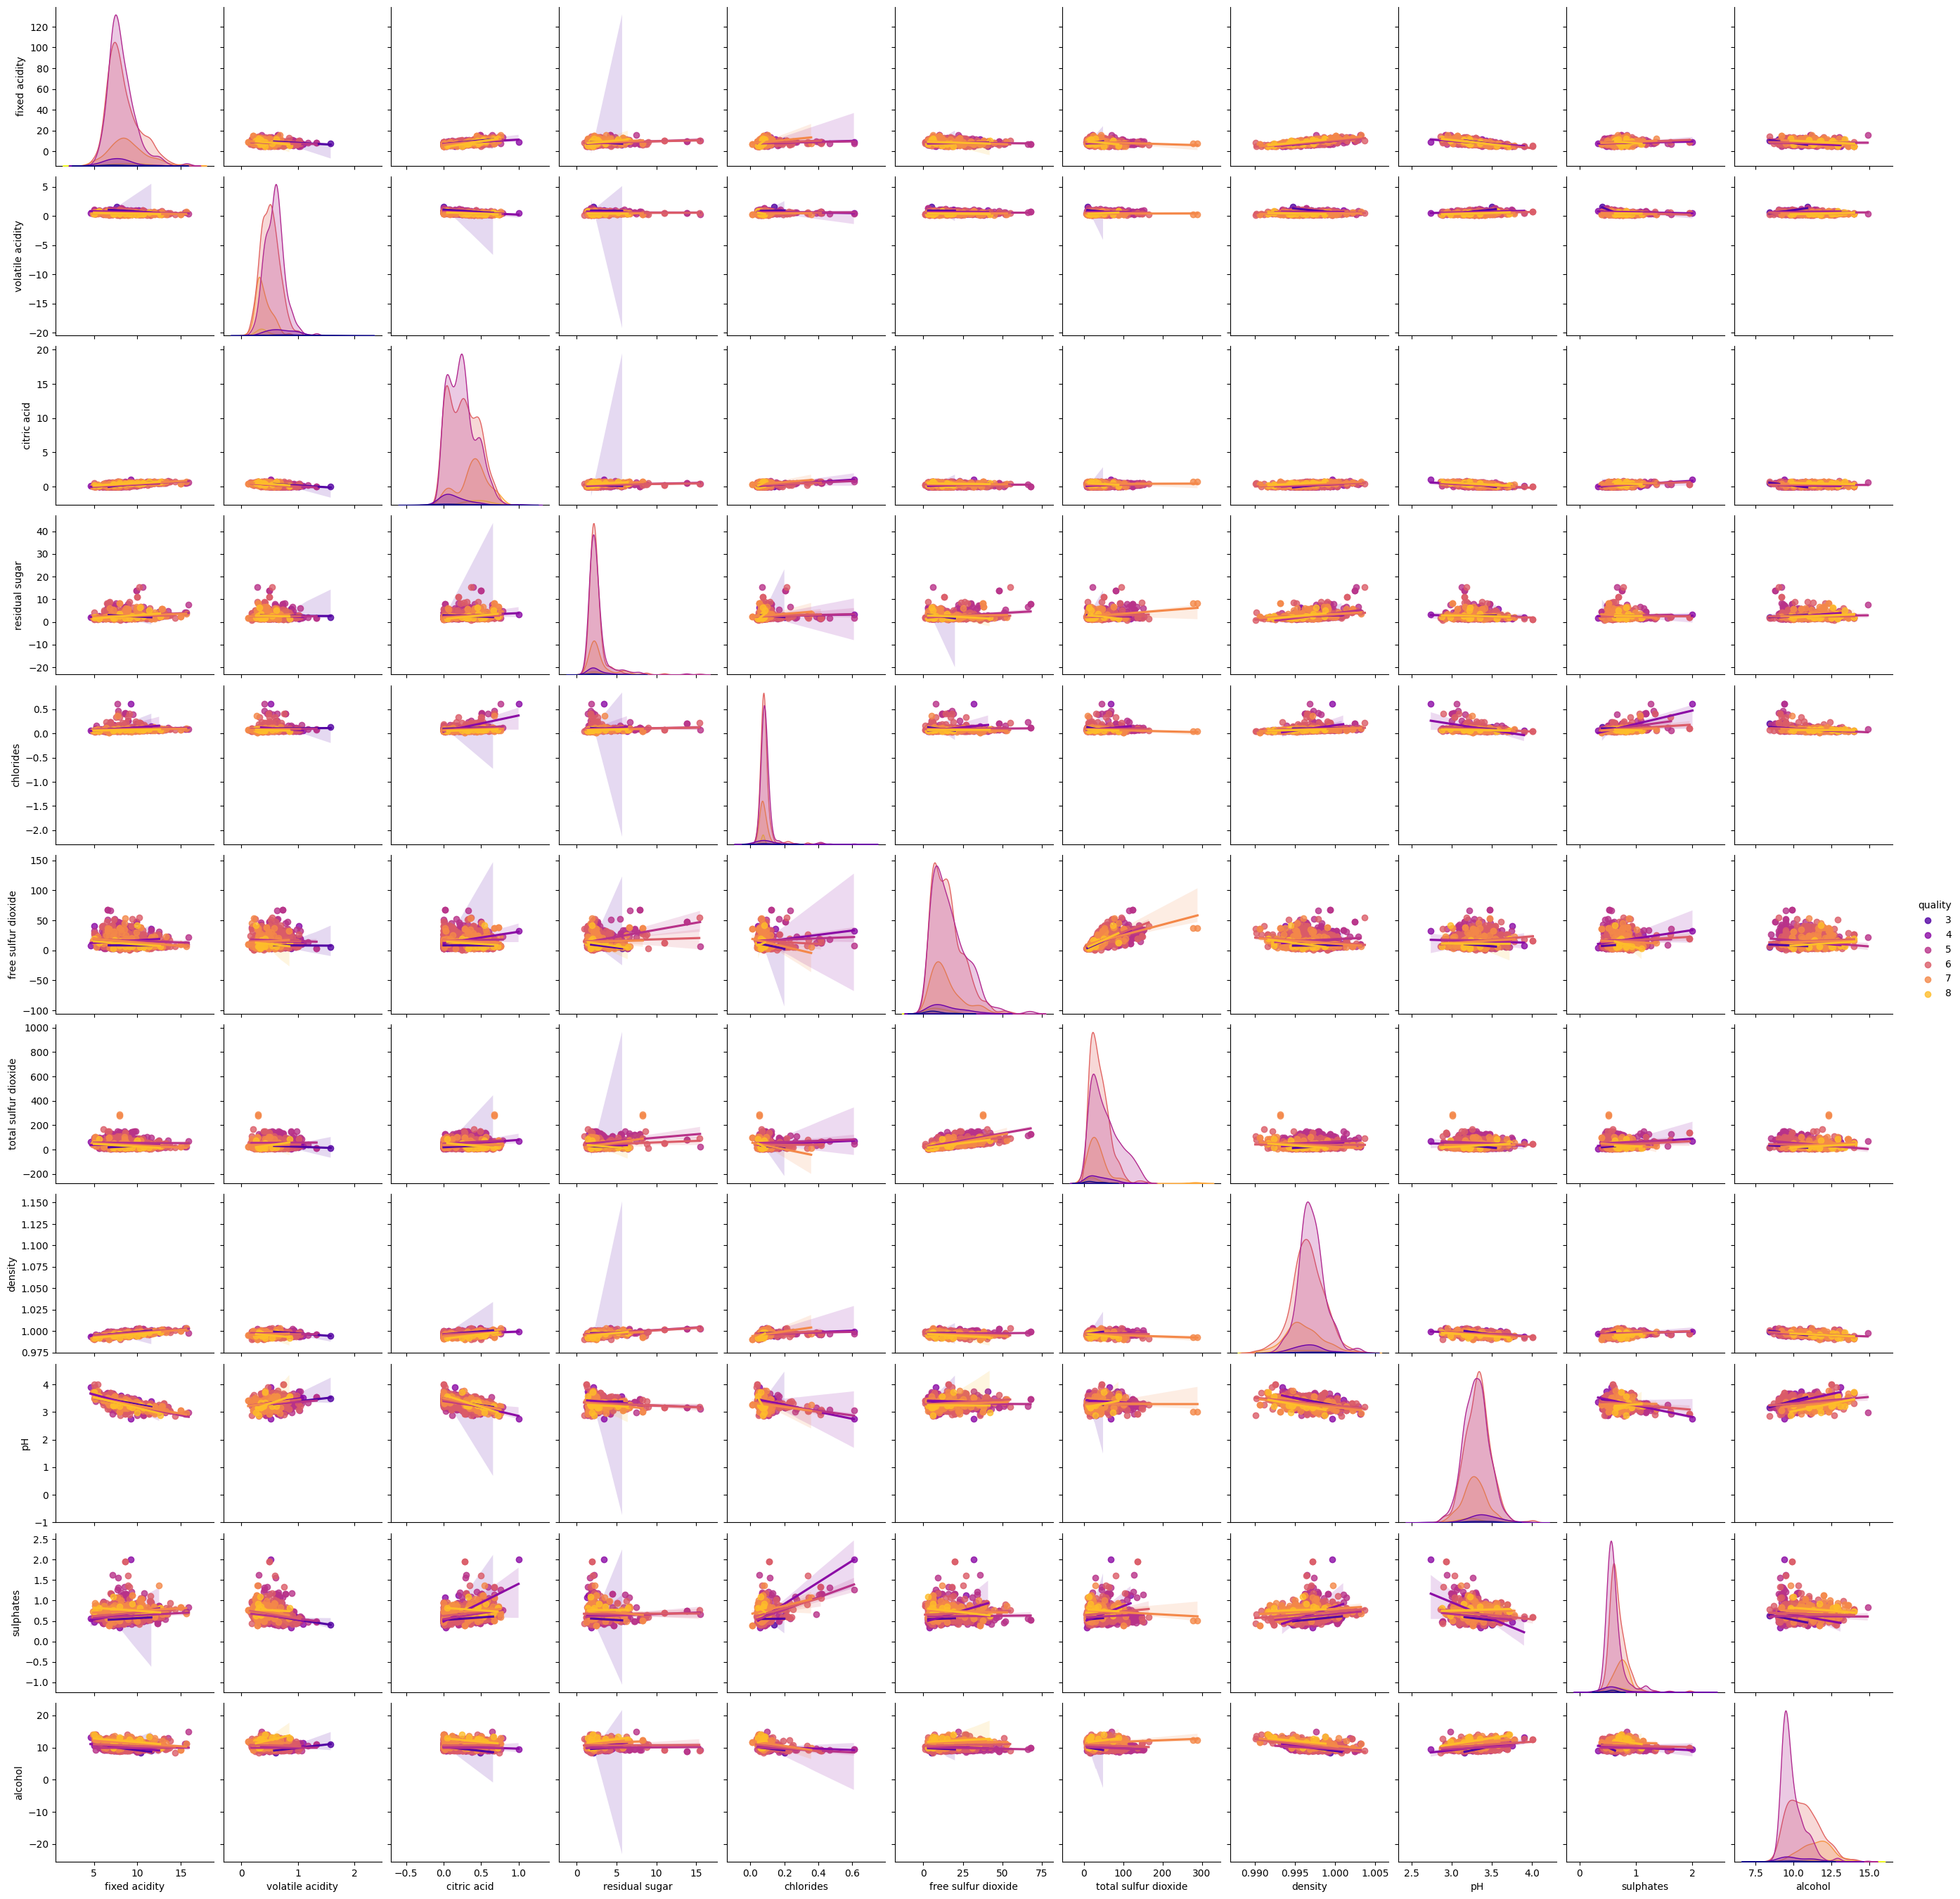

In [16]:
sns.pairplot(df,hue="quality",kind="reg",diag_kind='kde',palette='plasma')
plt.show()

### Feature Manipulation

In [17]:
#remove multicollinearity by using VIF technique
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
  vif=pd.DataFrame()
  vif['variables']=X.columns
  vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
  return vif

In [18]:
calc_vif(df.drop(columns=['quality']))

variables          VIF
0          fixed acidity    74.548916
1       volatile acidity    17.040785
2            citric acid     9.219394
3         residual sugar     5.014437
4              chlorides     6.717067
5    free sulfur dioxide     6.298331
6   total sulfur dioxide     6.224163
7                density  1435.099175
8                     pH  1043.339933
9              sulphates    21.510809
10               alcohol   123.962480

### 
* The VIF values indicate the presence of severe multicollinearity in the 'density' and 'pH' columns of the wine quality dataset. Additionally, 'fixed acidity', 'volatile acidity', 'sulphates', and 'alcohol' also exhibit high VIF values. This multicollinearity suggests that these variables are highly correlated, which can lead to unreliable regression results. To address this issue,I perform feature selection to eliminate redundant variables and improve the interpretability of the  model.

In [19]:
calc_vif(df.drop(columns=['quality','density','pH']))

variables        VIF
0         fixed acidity  37.052040
1      volatile acidity  15.773943
2           citric acid   8.520335
3        residual sugar   4.997840
4             chlorides   6.072592
5   free sulfur dioxide   6.250100
6  total sulfur dioxide   5.769331
7             sulphates  21.020290
8               alcohol  37.190727

### Feature Selection
* Dropping 'density' and 'pH' columns because of presence of severe Multicollinearity.

* Despite the presence of high multicollinearity in  'alcohol','sulphate' and 'fixed acidity' columns, it is crucial to retain these features for further prediction purposes, as they are deemed essential. 

In [20]:
df.drop(columns=['density','pH'],inplace=True)

In [21]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates',
       'alcohol', 'quality'],
      dtype='object')

In [22]:
features=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates',
       'alcohol']
features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'sulphates',
 'alcohol']

### Feature Transformation

In [23]:
df.skew()

fixed acidity           1.044930
volatile acidity        0.681547
citric acid             0.371561
residual sugar          4.361096
chlorides               6.026360
free sulfur dioxide     1.231261
total sulfur dioxide    1.665766
sulphates               2.497266
alcohol                 0.863313
quality                 0.286792
dtype: float64

In [24]:
# applying log transformation:
df['sulphates']=np.log10(df['sulphates']).skew()
df['residual sugar']=np.log10(df['residual sugar']).skew()
df['chlorides']=np.log10(df['chlorides']).skew()

In [25]:
df.skew()

fixed acidity           1.044930
volatile acidity        0.681547
citric acid             0.371561
residual sugar          0.000000
chlorides               0.000000
free sulfur dioxide     1.231261
total sulfur dioxide    1.665766
sulphates               0.000000
alcohol                 0.863313
quality                 0.286792
dtype: float64

### Feature Scaling

In [26]:
scaler=StandardScaler()
X=scaler.fit_transform(df.drop(columns='quality'))
X

array([[-0.52157961,  0.93933222, -1.36502663, ..., -0.3636101 ,
         0.        , -0.96338181],
       [-0.29259344,  1.94181282, -1.36502663, ...,  0.64347653,
         0.        , -0.59360107],
       [-0.29259344,  1.27349242, -1.16156762, ...,  0.24674544,
         0.        , -0.59360107],
       ...,
       [-1.20853813,  0.38239855, -0.9581086 , ..., -0.05843233,
         0.        ,  0.05351522],
       [-1.38027776,  0.10393172, -0.8563791 , ...,  0.15519211,
         0.        ,  0.70063152],
       [-1.38027776,  0.6330187 , -0.75464959, ..., -0.05843233,
         0.        , -0.22382033]])

### Label Binarization

In [27]:
y=df['quality'].apply(lambda y: 1 if y>=7 else 0)

### Data Splitting

In [28]:
X,y

(array([[-0.52157961,  0.93933222, -1.36502663, ..., -0.3636101 ,
          0.        , -0.96338181],
        [-0.29259344,  1.94181282, -1.36502663, ...,  0.64347653,
          0.        , -0.59360107],
        [-0.29259344,  1.27349242, -1.16156762, ...,  0.24674544,
          0.        , -0.59360107],
        ...,
        [-1.20853813,  0.38239855, -0.9581086 , ..., -0.05843233,
          0.        ,  0.05351522],
        [-1.38027776,  0.10393172, -0.8563791 , ...,  0.15519211,
          0.        ,  0.70063152],
        [-1.38027776,  0.6330187 , -0.75464959, ..., -0.05843233,
          0.        , -0.22382033]]),
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 1138    0
 1139    0
 1140    0
 1141    0
 1142    0
 Name: quality, Length: 1143, dtype: int64)

In [29]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19, stratify=y)

### Handling Imbalanced Dataset

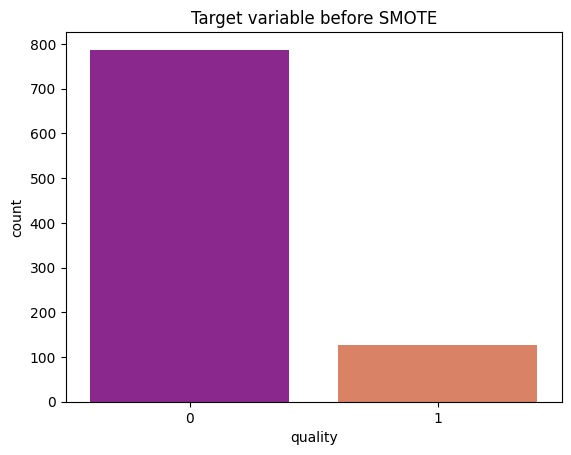

In [30]:
sns.countplot(x=y_train,palette='plasma')
plt.title('Target variable before SMOTE')
plt.show()

In [31]:
# Oversampling using SMOTE
smote=SMOTE(random_state=19)
X_smote,y_smote= smote.fit_resample(X_train,y_train)

print('Samples in the original dataset: ', len(y_train))
print('Samples in the resampled dataset: ', len(y_smote))
     

Samples in the original dataset:  914
Samples in the resampled dataset:  1574


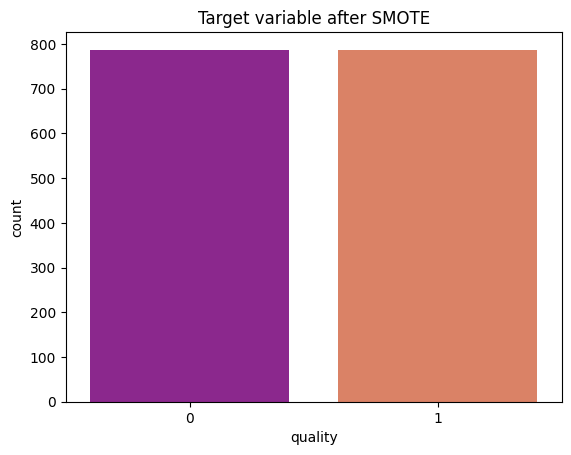

In [32]:
sns.countplot(x=y_smote,palette='plasma')
plt.title('Target variable after SMOTE')
plt.show()
     

###  ML Model Implementation

In [33]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    '''The function will take model, x train, x test, y train, y test
    and then it will fit the model, then make predictions on the trained model,
    it will then print roc-auc score of train and test, then plot the roc, auc curve,
    print confusion matrix for train and test, then print classification report for train and test,
    then plot the feature importances if the model has feature importances,
    and finally it will return the following scores as a list:
    recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test
    '''

    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_prob_train = model.predict_proba(X_train)[:,1]
    pred_prob_test = model.predict_proba(X_test)[:,1]

    # calculate ROC AUC score
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    print("\nTrain ROC AUC:", roc_auc_train)
    print("Test ROC AUC:", roc_auc_test)

    # plot the ROC curve
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_prob_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_prob_test)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr_train, tpr_train, label="Train ROC AUC: {:.2f}".format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC: {:.2f}".format(roc_auc_test))
    plt.legend()
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # calculate confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    print("\nConfusion Matrix:")
    sns.heatmap(cm_train, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="BuPu", fmt='.4g', ax=ax[0])
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title("Train Confusion Matrix")

    sns.heatmap(cm_test, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="BuPu", fmt='.4g', ax=ax[1])
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    ax[1].set_title("Test Confusion Matrix")

    plt.tight_layout()
    plt.show()


    # calculate classification report
    cr_train = classification_report(y_train, y_pred_train, output_dict=True)
    cr_test = classification_report(y_test, y_pred_test, output_dict=True)
    print("\nTrain Classification Report:")
    crt = pd.DataFrame(cr_train).T
    print(crt.to_markdown())
    # sns.heatmap(pd.DataFrame(cr_train).T.iloc[:, :-1], annot=True, cmap="Blues")
    print("\nTest Classification Report:")
    crt2 = pd.DataFrame(cr_test).T
    print(crt2.to_markdown())
    # sns.heatmap(pd.DataFrame(cr_test).T.iloc[:, :-1], annot=True, cmap="Blues")

    try:
      try:
        feature_importance = model.feature_importances_
      except:
        feature_importance = model.coef_
      feature_importance = np.absolute(feature_importance)
      if len(feature_importance)==len(features):
        pass
      else:
        feature_importance = feature_importance[0]


      feat = pd.Series(feature_importance, index=features)
      feat = feat.sort_values(ascending=True)
      plt.figure(figsize=(10,6))
      plt.title('Feature Importances for '+str(model), fontsize = 18)
      plt.xlabel('Relative Importance')
      feat.plot(kind='barh')
    except AttributeError:
        print("\nThe model does not have feature importances attribute.")

    precision_train = cr_train['weighted avg']['precision']
    precision_test = cr_test['weighted avg']['precision']

    recall_train = cr_train['weighted avg']['recall']
    recall_test = cr_test['weighted avg']['recall']

    acc_train = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    acc_test = accuracy_score(y_true = y_test, y_pred = y_pred_test)

    F1_train = cr_train['weighted avg']['f1-score']
    F1_test = cr_test['weighted avg']['f1-score']

    model_score = [precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test ]
    return model_score

In [34]:
# Create a score dataframe
score = pd.DataFrame(index = ['Precision Train', 'Precision Test','Recall Train','Recall Test','Accuracy Train', 'Accuracy Test','ROC-AUC Train', 'ROC-AUC Test','F1 macro Train', 'F1 macro Test'])
     

### ML Model -1 : Logistic Regression

In [35]:
lr_model = LogisticRegression(fit_intercept=True, max_iter=10000)


Train ROC AUC: 0.7998729351969504
Test ROC AUC: 0.7949714467005077


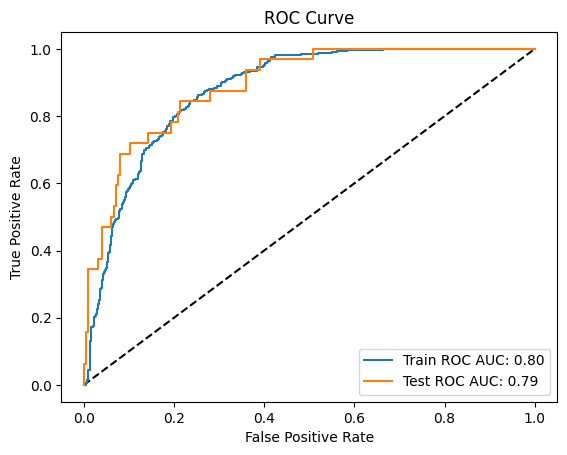


Confusion Matrix:


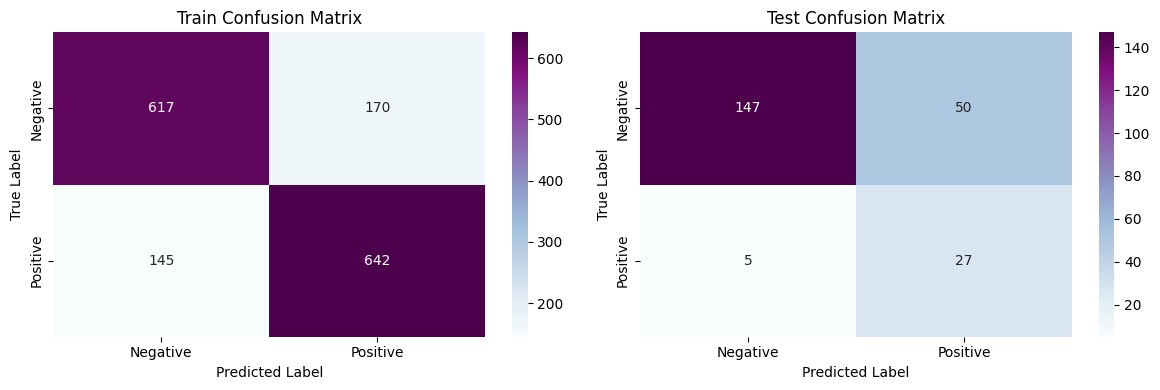


Train Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.809711 | 0.78399  |   0.796643 |  787        |
| 1            |    0.79064  | 0.815756 |   0.803002 |  787        |
| accuracy     |    0.799873 | 0.799873 |   0.799873 |    0.799873 |
| macro avg    |    0.800176 | 0.799873 |   0.799822 | 1574        |
| weighted avg |    0.800176 | 0.799873 |   0.799822 | 1574        |

Test Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    0.967105 | 0.746193 |   0.842407 | 197        |
| 1            |    0.350649 | 0.84375  |   0.495413 |  32        |
| accuracy     |    0.759825 | 0.759825 |   0.759825 |   0.759825 |
| macro avg    |    0.658877 | 0.794971 |   0.66891  | 229        |
| weighted avg |    0.880963 | 0.759825 |   0.7939

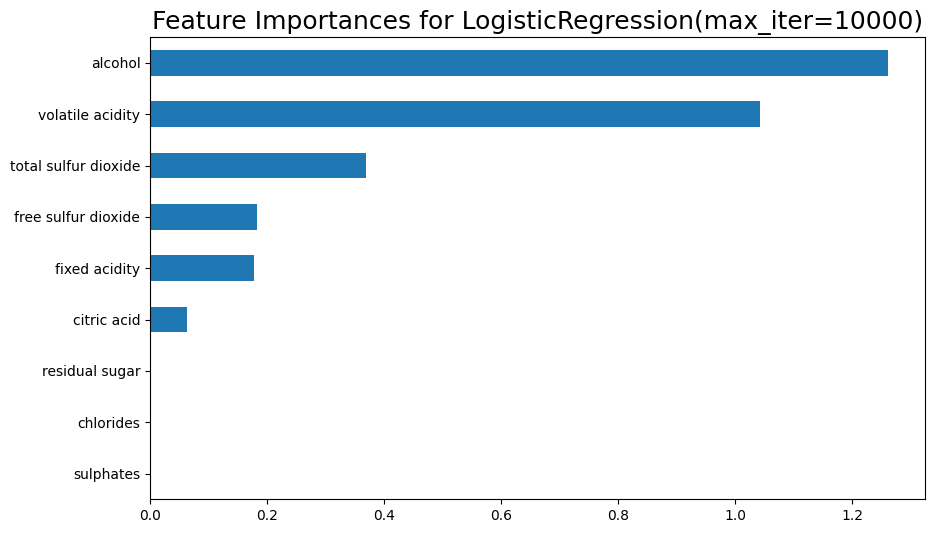

In [36]:
lr_score = evaluate_model(lr_model, X_smote, X_test, y_smote, y_test)

In [37]:
score['Logistic regression'] = lr_score
score

Logistic regression
Precision Train             0.800176
Precision Test              0.880963
Recall Train                0.799873
Recall Test                 0.759825
Accuracy Train              0.799873
Accuracy Test               0.759825
ROC-AUC Train               0.799873
ROC-AUC Test                0.794971
F1 macro Train              0.799822
F1 macro Test               0.793919

### ML Model -2 : Decision Tree

In [38]:
dt = DecisionTreeClassifier(random_state=0)


Train ROC AUC: 1.0
Test ROC AUC: 0.7334232233502538


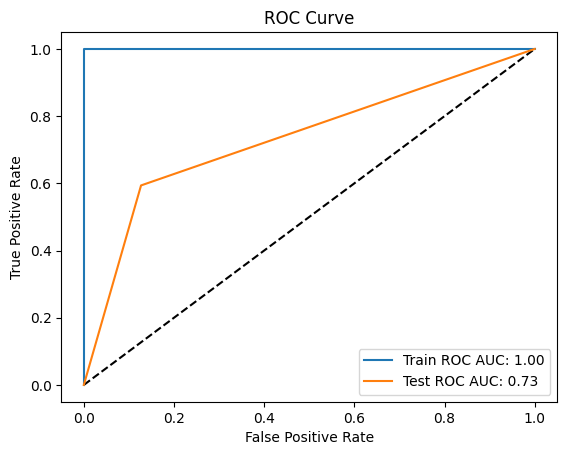


Confusion Matrix:


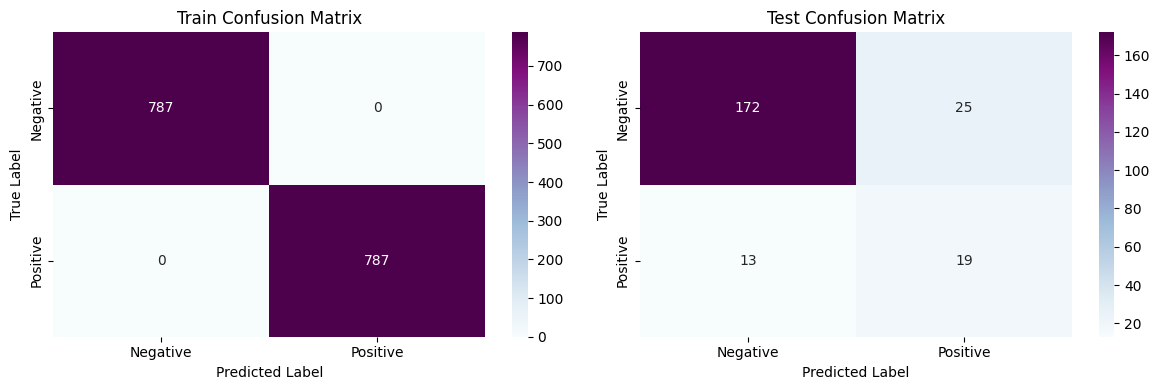


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |       787 |
| 1            |           1 |        1 |          1 |       787 |
| accuracy     |           1 |        1 |          1 |         1 |
| macro avg    |           1 |        1 |          1 |      1574 |
| weighted avg |           1 |        1 |          1 |      1574 |

Test Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    0.92973  | 0.873096 |   0.900524 | 197        |
| 1            |    0.431818 | 0.59375  |   0.5      |  32        |
| accuracy     |    0.834061 | 0.834061 |   0.834061 |   0.834061 |
| macro avg    |    0.680774 | 0.733423 |   0.700262 | 229        |
| weighted avg |    0.860153 | 0.834061 |   0.844555 | 229      

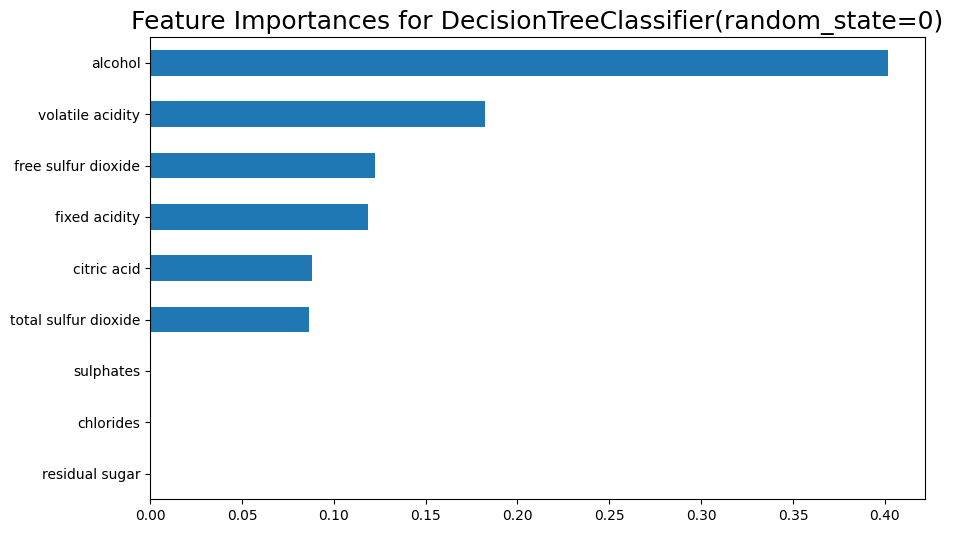

In [39]:
dt_score = evaluate_model(dt, X_smote, X_test, y_smote, y_test)

In [40]:
score['Decision Tree'] = dt_score
score

Logistic regression  Decision Tree
Precision Train             0.800176       1.000000
Precision Test              0.880963       0.860153
Recall Train                0.799873       1.000000
Recall Test                 0.759825       0.834061
Accuracy Train              0.799873       1.000000
Accuracy Test               0.759825       0.834061
ROC-AUC Train               0.799873       1.000000
ROC-AUC Test                0.794971       0.733423
F1 macro Train              0.799822       1.000000
F1 macro Test               0.793919       0.844555

### ML Model -3 : Random Forest

In [41]:
rf = RandomForestClassifier(random_state=0)


Train ROC AUC: 1.0
Test ROC AUC: 0.8343908629441624


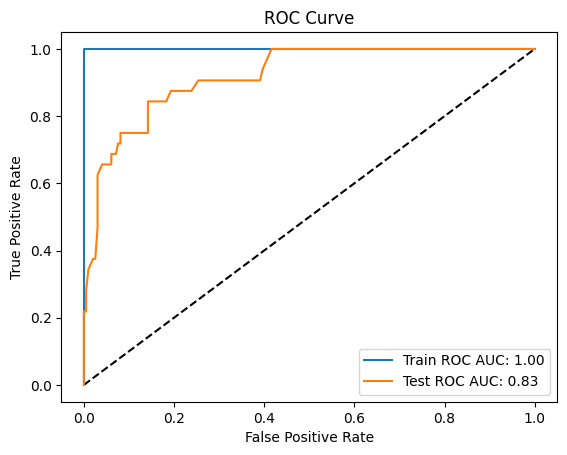


Confusion Matrix:


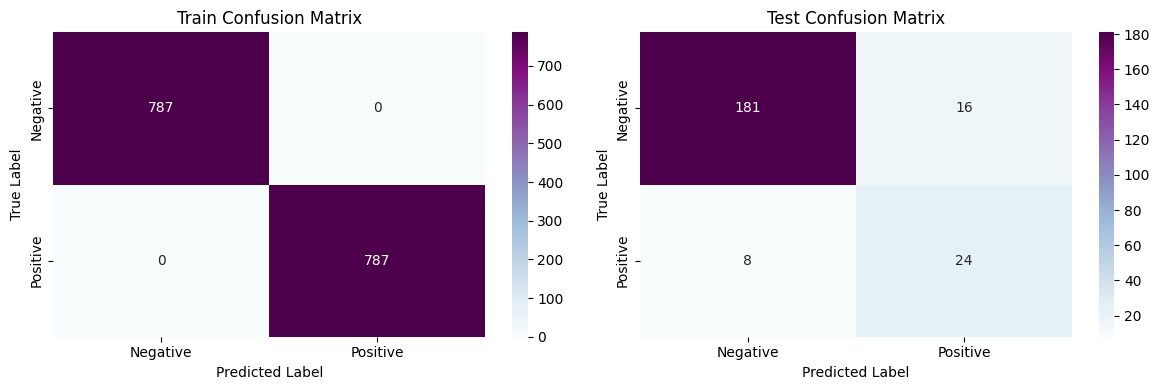


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |       787 |
| 1            |           1 |        1 |          1 |       787 |
| accuracy     |           1 |        1 |          1 |         1 |
| macro avg    |           1 |        1 |          1 |      1574 |
| weighted avg |           1 |        1 |          1 |      1574 |

Test Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    0.957672 | 0.918782 |   0.937824 | 197        |
| 1            |    0.6      | 0.75     |   0.666667 |  32        |
| accuracy     |    0.895197 | 0.895197 |   0.895197 |   0.895197 |
| macro avg    |    0.778836 | 0.834391 |   0.802245 | 229        |
| weighted avg |    0.907692 | 0.895197 |   0.899933 | 229      

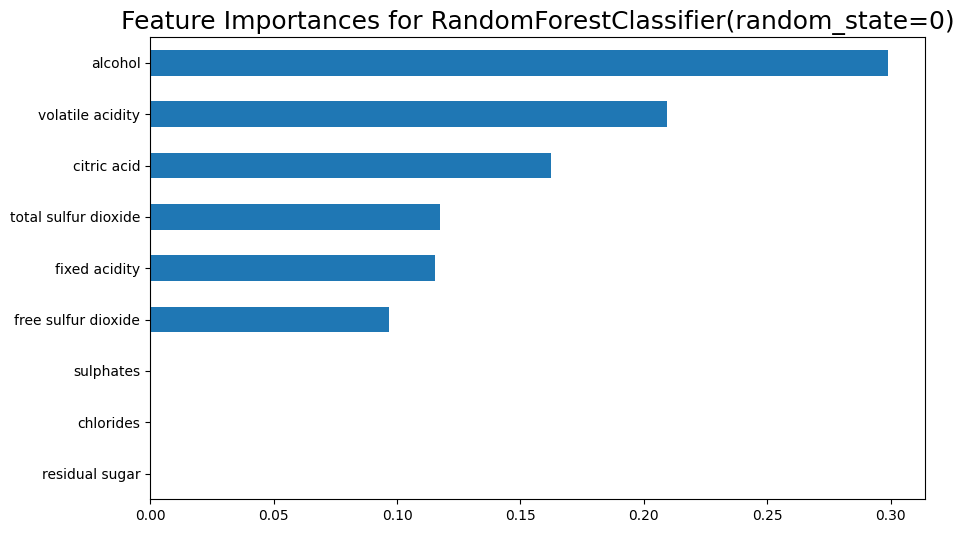

In [42]:
rf_score = evaluate_model(rf, X_smote, X_test, y_smote, y_test)

In [43]:
score['Random Forest'] = rf_score
score

Logistic regression  Decision Tree  Random Forest
Precision Train             0.800176       1.000000       1.000000
Precision Test              0.880963       0.860153       0.907692
Recall Train                0.799873       1.000000       1.000000
Recall Test                 0.759825       0.834061       0.895197
Accuracy Train              0.799873       1.000000       1.000000
Accuracy Test               0.759825       0.834061       0.895197
ROC-AUC Train               0.799873       1.000000       1.000000
ROC-AUC Test                0.794971       0.733423       0.834391
F1 macro Train              0.799822       1.000000       1.000000
F1 macro Test               0.793919       0.844555       0.899933

In [44]:
svc=SVC(random_state=0,probability=True)


Train ROC AUC: 0.863405336721728
Test ROC AUC: 0.7818845177664975


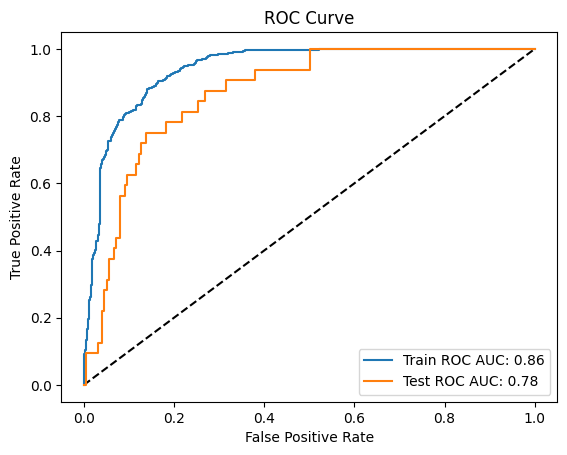


Confusion Matrix:


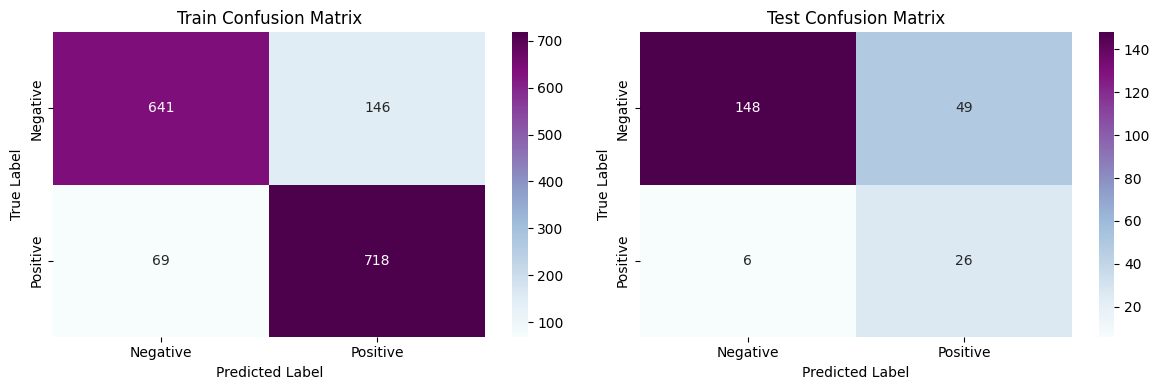


Train Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.902817 | 0.814485 |   0.856379 |  787        |
| 1            |    0.831019 | 0.912325 |   0.869776 |  787        |
| accuracy     |    0.863405 | 0.863405 |   0.863405 |    0.863405 |
| macro avg    |    0.866918 | 0.863405 |   0.863078 | 1574        |
| weighted avg |    0.866918 | 0.863405 |   0.863078 | 1574        |

Test Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    0.961039 | 0.751269 |   0.843305 | 197        |
| 1            |    0.346667 | 0.8125   |   0.485981 |  32        |
| accuracy     |    0.759825 | 0.759825 |   0.759825 |   0.759825 |
| macro avg    |    0.653853 | 0.781885 |   0.664643 | 229        |
| weighted avg |    0.875188 | 0.759825 |   0.7933

In [45]:
svc_score=evaluate_model(svc, X_smote, X_test, y_smote, y_test)

In [46]:
score['SVC'] = rf_score
score

Logistic regression  Decision Tree  Random Forest       SVC
Precision Train             0.800176       1.000000       1.000000  1.000000
Precision Test              0.880963       0.860153       0.907692  0.907692
Recall Train                0.799873       1.000000       1.000000  1.000000
Recall Test                 0.759825       0.834061       0.895197  0.895197
Accuracy Train              0.799873       1.000000       1.000000  1.000000
Accuracy Test               0.759825       0.834061       0.895197  0.895197
ROC-AUC Train               0.799873       1.000000       1.000000  1.000000
ROC-AUC Test                0.794971       0.733423       0.834391  0.834391
F1 macro Train              0.799822       1.000000       1.000000  1.000000
F1 macro Test               0.793919       0.844555       0.899933  0.899933

### Logistic Regression : Cross- Validation & Hyperparameter Tuning

In [47]:
param_grid = {'C': [100,10,1,0.1,0.01,0.001,0.0001],
              'penalty': ['l1', 'l2'],
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Initializing the logistic regression model
logreg = LogisticRegression(fit_intercept=True, max_iter=10000, random_state=0)


# Using GridSearchCV to tune the hyperparameters using cross-validation
grid = GridSearchCV(logreg, param_grid, cv=5)
grid.fit(X_smote, y_smote)

best_params = grid.best_params_
# The best hyperparameters found by GridSearchCV
print("Best hyperparameters: ", best_params)

Best hyperparameters:  {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [48]:
lr_model2 = LogisticRegression(C=best_params['C'],
                                  penalty=best_params['penalty'],
                                  solver=best_params['solver'],
                                  max_iter=10000, random_state=0)


Train ROC AUC: 0.8005082592121983
Test ROC AUC: 0.7949714467005077


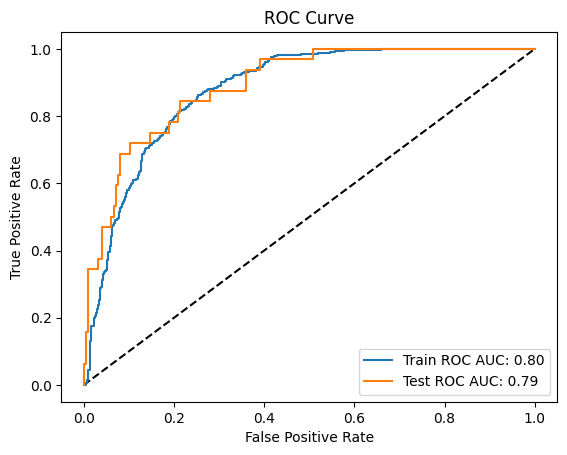


Confusion Matrix:


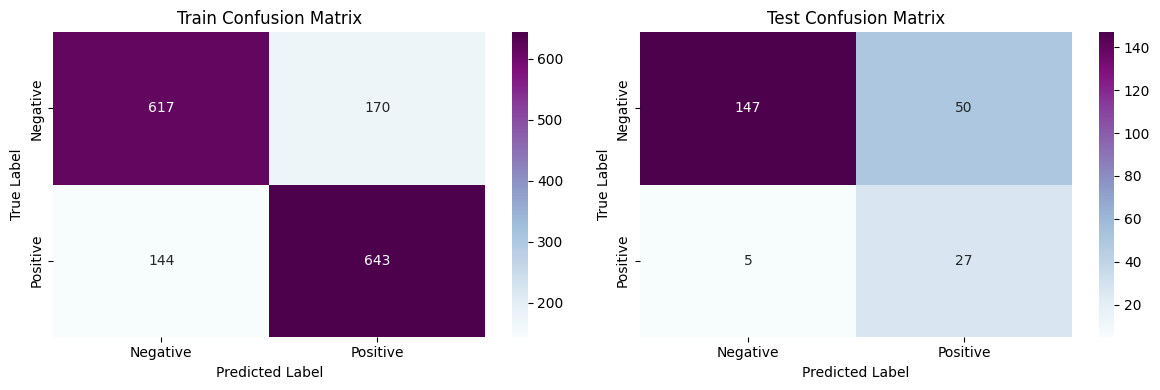


Train Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.810775 | 0.78399  |   0.797158 |  787        |
| 1            |    0.790898 | 0.817027 |   0.80375  |  787        |
| accuracy     |    0.800508 | 0.800508 |   0.800508 |    0.800508 |
| macro avg    |    0.800837 | 0.800508 |   0.800454 | 1574        |
| weighted avg |    0.800837 | 0.800508 |   0.800454 | 1574        |

Test Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    0.967105 | 0.746193 |   0.842407 | 197        |
| 1            |    0.350649 | 0.84375  |   0.495413 |  32        |
| accuracy     |    0.759825 | 0.759825 |   0.759825 |   0.759825 |
| macro avg    |    0.658877 | 0.794971 |   0.66891  | 229        |
| weighted avg |    0.880963 | 0.759825 |   0.7939

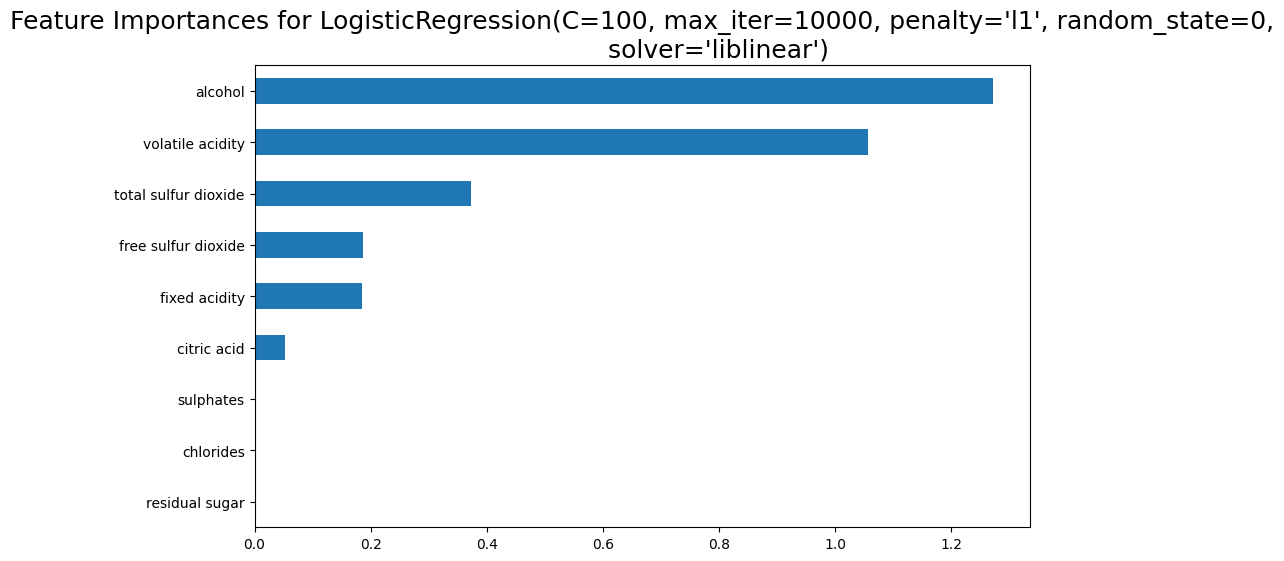

In [49]:
lr_score2 = evaluate_model(lr_model2, X_smote, X_test, y_smote, y_test)

In [50]:
score['Logistic regression tuned'] = lr_score2
score

Logistic regression  Decision Tree  Random Forest       SVC   
Precision Train             0.800176       1.000000       1.000000  1.000000  \
Precision Test              0.880963       0.860153       0.907692  0.907692   
Recall Train                0.799873       1.000000       1.000000  1.000000   
Recall Test                 0.759825       0.834061       0.895197  0.895197   
Accuracy Train              0.799873       1.000000       1.000000  1.000000   
Accuracy Test               0.759825       0.834061       0.895197  0.895197   
ROC-AUC Train               0.799873       1.000000       1.000000  1.000000   
ROC-AUC Test                0.794971       0.733423       0.834391  0.834391   
F1 macro Train              0.799822       1.000000       1.000000  1.000000   
F1 macro Test               0.793919       0.844555       0.899933  0.899933   

                 Logistic regression tuned  
Precision Train                   0.800837  
Precision Test                    0.880963  
Recall Train                      0.800508  
Recall Test                       0.759825  
Accuracy Train                    0.800508  
Accuracy Test                     0.759825  
ROC-AUC Train                     0.800508  
ROC-AUC Test                      0.794971  
F1 macro Train                    0.800454  
F1 macro Test                     0.793919

### Conclusion:

Based on the observations, it is apparent that models such as Decision Tree, Random Forest, and SVC may suffer from overfitting issues. However, Logistic Regression demonstrates satisfactory performance on both the training and test datasets. By conducting hyperparameter tuning, the performance of Logistic Regression can be significantly enhanced, leading to improved predictive accuracy. Therefore, the optimal choice for this dataset is to utilize Logistic Regression with carefully tuned hyperparameters to obtain superior results compared to the default configuration.